In [1]:
import numpy as np
import matplotlib.pyplot as plt

import climxtract as cxt

## ClimXtract: A Python Toolkit for Standardizing High-Resolution Climate Datasets for Austria

ClimXtract provides a modular pipeline for preparing high-resolution climate dataset for regional analysis. Its three capabilities are **downloading**, **regridding**, and **masking**.

In this example notebook we are going to download and preprocess surface temperature data from six major climate datasets relevant for the Austrian Domain:
- ÖKS15
- SPARTACUS
- EURO-CORDEX
- E-OBS
- DestinE Climate DT
- ERA5-Land

Note that working with ERA instead of ERA-Land is done by changing the keyword `model_global` in the `load` function.

Before downloading the data, we need to define the output paths where the datasets will be saved.

In [2]:
# each variable contains the path to be used for the downloaded datasets (needs to be changed accordingly by users!)
output_path_oeks15 = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'
output_path_spartacus = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'
output_path_cordex = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'
output_path_eobs = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'
output_path_destine = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'
output_path_era5 = '/jetfs/scratch/mmeindl/HighResLearn/download/example_data'

### 1. Downloading

The datasets mentioned above differ in format, temporal and spatial resolution, and their access method. **ClimXtract** handles this heterogeneity through automated interfaces such as *wget*, *cdsapi*, and the *ESGF PyClient*. In all following downloads (1.1-1.6), these interfaces are used in the background of the `cxt.load()` function.

In addition to the type of the dataset, further parameters have to be specified.
These parameters generally include:

- `model_global`: *name of the global climate model*
- `model_regional`: *name of the regional climate model (only necessary for ÖKS15 and EURO-CORDEX)*
- `variable`: *name of the variable (e.g. tas for surface temperature)*
- `experiment`: *name of the climate change scenario (e.g rcp45)*
- `ens`: *ensemble member (e.g r1i1p1)*
- `start`: *start date (e.g. 20160101)*
- `end`: *end date (e.g. 20201231)*
- `output_path`: *output path where the downloaded data should be stored*

#### 1.1 ÖKS15

*ÖKS15* data is retrieved using HTTP filelisting and wget. The actual data in netcdf format is located on the Geosphere Austria datahub.

Note that the complete dataset (1971-2100) is downloaded, therefore `start` and `end` is `None`.

In [3]:
# load the dataset for 'tas' variable of 'oeks15' type
t_oeks15 = cxt.load(type='oeks15', model_global='MPI-M-MPI-ESM-LR', model_regional='SMHI-RCA4', resolution=None, variable='tas', experiment='rcp45', ens='r1i1p1', start=None, end=None, output_path=output_path_oeks15)

Loaded ÖKS15 data successfully.


The function `cxt.load()` returns a tuple containing both the path of the downloaded file (as string) and the xarray object.

In [4]:
# show path and metadata of the downloaded oeks15 file
print(t_oeks15[0], t_oeks15[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_SDM_MPI-M-MPI-ESM-LR_rcp45_r1i1p1_SMHI-RCA4.nc <xarray.Dataset> Size: 32GB
Dimensions:                  (time: 47482, y: 297, x: 575, bnds: 2)
Coordinates:
  * time                     (time) datetime64[ns] 380kB 1971-01-01T12:00:00 ...
  * y                        (y) int32 1kB 275500 276500 ... 570500 571500
  * x                        (x) int32 2kB 111500 112500 ... 684500 685500
    height                   float64 8B ...
    lat                      (y, x) float64 1MB ...
    lon                      (y, x) float64 1MB ...
Dimensions without coordinates: bnds
Data variables:
    tas                      (time, y, x) float32 32GB ...
    lambert_conformal_conic  int32 4B ...
    time_bnds                (time, bnds) datetime64[ns] 760kB ...
Attributes:
    comment:      Bias corrected (scaled distribution mapping) data of the EU...
    contact:      Armin Leuprecht <armin.leuprecht@uni-graz.at>
    institution:  Wegener

#### 1.2 SPARTACUS

*SPARTACUS v2.1* data is retrieved using HTTP filelisting and wget. The actual data in netcdf format is located on the Geosphere Austria datahub.

Since this type is an observational dataset, only the variable name, the time period to be downloaded and the output path must be specified.

Data is available on daily basis (from 1961 onwards), but is stored in yearly files (therfore `start` and `end` are annual numbers).

Note that the retrieved daily temperature (in this example for the year 2020) is the average of daily maximum and minimum temperatures provided by SPARTACUS.

In [5]:
# load the dataset for 'tas' variable of 'spartacus' type
t_spartacus = cxt.load(type='spartacus', model_global=None, model_regional=None,  resolution=None, variable='tas', experiment=None, ens=None, start='2020', end='2020', output_path=output_path_spartacus)

Loaded SPARTACUS data successfully.


In [6]:
# show path and metadata of downloaded spartacus file
print(t_spartacus[0], t_spartacus[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_spartacusv2.1_2020-2020.nc <xarray.Dataset> Size: 563MB
Dimensions:                  (time: 366, x: 584, y: 329)
Coordinates:
  * time                     (time) datetime64[ns] 3kB 2020-01-01 ... 2020-12-31
  * x                        (x) float64 5kB 1.125e+05 1.135e+05 ... 6.955e+05
  * y                        (y) float64 3kB 2.585e+05 2.595e+05 ... 5.865e+05
Data variables:
    lambert_conformal_conic  int32 4B ...
    tas                      (time, y, x) float64 563MB ...
Attributes:
    CDI:          Climate Data Interface version 2.5.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Mon Dec 15 10:31:10 2025: cdo -O -s -setgrid,/jetfs/home/mm...
    CDO:          Climate Data Operators version 2.5.0 (https://mpimet.mpg.de...


#### 1.3 EURO-CORDEX

*EURO-CORDEX* data is retrieved using the ESGF PyClient. The actual data in netcdf format is located on ESGF nodes.

In [7]:
# load the dataset for 'tas' variable of 'euro-cordex' type
t_eurocordex = cxt.load(type='eurocordex', model_global='MPI-M-MPI-ESM-LR', model_regional='RCA4', resolution='EUR-11', variable='tas', experiment='rcp45', ens='r1i1p1', start='20160101', end='20201231', output_path=output_path_cordex) 

Loaded EURO-CORDEX data successfully.


In [8]:
# show path and metadata of downloaded euro-cordex file
print(t_eurocordex[0], t_eurocordex[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_MPI-M-MPI-ESM-LR_rcp45_r1i1p1_RCA4_20160101-20201231.nc <xarray.Dataset> Size: 1GB
Dimensions:       (time: 1827, bnds: 2, rlat: 412, rlon: 424)
Coordinates:
  * time          (time) datetime64[ns] 15kB 2016-01-01T12:00:00 ... 2020-12-...
    lon           (rlat, rlon) float64 1MB ...
    lat           (rlat, rlon) float64 1MB ...
  * rlon          (rlon) float64 3kB -28.38 -28.27 -28.16 ... 17.94 18.05 18.16
  * rlat          (rlat) float64 3kB -23.38 -23.27 -23.16 ... 21.62 21.73 21.84
    height        float64 8B ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) datetime64[ns] 29kB ...
    rotated_pole  |S1 1B ...
    tas           (time, rlat, rlon) float32 1GB ...
Attributes: (12/25)
    CDI:                            Climate Data Interface version 2.5.0 (htt...
    Conventions:                    CF-1.4
    institution:                    Swedish Meteorological and Hydrological I.

#### 1.4 E-OBS

*E-OBS* is again an observational dataset, covering the European domain.

Note that version *30.0e* of the dataset is downloaded, which includes the period 1950-01-01 to 2024-06-30 as speficied in the `start` and `end` attributes of the `cxt.load` function.

In [9]:
# load the dataset for 'tas' variable of 'eobs' type
t_eobs = cxt.load(type='eobs', model_global=None, model_regional=None, resolution=None, variable='tas', experiment=None, ens=None, start='20200101', end='20201231', output_path=output_path_eobs)

Loaded E-OBS data successfully.


In [10]:
# show path and metadata of downloaded eobs file
print(t_eobs[0], t_eobs[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_e-obs31.e_20200101-20201231.nc <xarray.Dataset> Size: 480MB
Dimensions:    (latitude: 465, longitude: 705, time: 366)
Coordinates:
  * latitude   (latitude) float64 4kB 25.05 25.15 25.25 ... 71.25 71.35 71.45
  * longitude  (longitude) float64 6kB -24.95 -24.85 -24.75 ... 45.35 45.45
  * time       (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    tas        (time, latitude, longitude) float32 480MB ...
Attributes:
    E-OBS_version:  30.0e
    Conventions:    CF-1.4
    References:     http://surfobs.climate.copernicus.eu/dataaccess/access_eo...
    history:        Fri Aug 30 10:36:09 2024: ncks --no-abc -d time,0,27209 /...
    NCO:            netCDF Operators version 5.1.8 (Homepage = http://nco.sf....


#### 1.5 DestinE Climate DT

Recently, projects such as *Destination Earth* have begun to generate global simulations directly at kilometer-scale resolutions using state-of-the-art Earth system models like ICON and IFS.
    
Data is retrieved using the `polytope client` via the DestinE platform. To access the datasets you need to register on the [Destination Earth Platform](https://platform.destine.eu/). In order to get full access to the data, one has to [upgrade the access](https://platform.destine.eu/access-policy-upgrade/) by selecting the appropriate user category (e.g., academia & research). Your request will be reviewed and you will be notified on the acceptance.

After your request has been successfully accepted, a token from the Destination Earth Service Platfrom (DESP) can be retrieved:

`python desp-authentication.py`

You will then be prompted to enter your username and password.

The script automatically places your token in `~/.polytopeapirc` where the `polytope client` will pickit up.

Both a historical (*hist*) and a climate change scenario (*SSP3-7.0*) simulation are available, as specified in the `experiment` attribute.

Hourly data is downloaded in grib format, from which daily averages are calculated and saved as netcdf file.

In [11]:
# load the dataset for 'tas' variable of 'destine' type
t_destine = cxt.load(type='destine', model_global='ICON', model_regional=None, resolution=None, variable='tas', experiment='SSP3-7.0', ens=None, start='20200901', end='20200930', output_path=output_path_destine)

Loaded DestinE Climate DT data successfully.


In [12]:
# show path and metadata of downloaded destine file
print(t_destine[0], t_destine[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_ICON_20200901-20200930.nc <xarray.Dataset> Size: 2GB
Dimensions:  (time: 30, x: 12582912)
Coordinates:
  * time     (time) datetime64[ns] 240B 2020-09-01 2020-09-02 ... 2020-09-30
Dimensions without coordinates: x
Data variables:
    healpix  int32 4B ...
    tas      (time, x) float32 2GB ...
Attributes:
    CDI:                     Climate Data Interface version 2.5.0 (https://mp...
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    history:                 Mon Dec 15 10:51:52 2025: cdo -O -s -setgrid,/je...
    CDO:                     Climate Data Operators version 2.5.0 (https://mp...


#### 1.6 ERA5-Land

Data is available at the [Copernicus Climate Data Store](https://cds.climate.copernicus.eu/) and can be downloaded via the [CDS API](https://cds.climate.copernicus.eu/how-to-api). In addition, ERA5-Land data from 1950 to present is also available.

In oder to use the CDS API, the CDS API personal access token has to be setup:
1. If you do not have an account yet, please [register](https://accounts.ecmwf.int/auth/realms/ecmwf/login-actions/registration?execution=c4f93b9c-f4e7-40e7-a6d4-94fb59e7a5e6&client_id=cds&tab_id=KEZjPuIIXiQ).
2. If you are not logged in, please [login](https://accounts.ecmwf.int/auth/realms/ecmwf/protocol/openid-connect/auth?client_id=cds&scope=openid%20email&response_type=code&redirect_uri=https%3A%2F%2Fcds.climate.copernicus.eu%2Fapi%2Fauth%2Fcallback%2Fkeycloak&state=HLLwusl7uPsbQsnaNS-Io99y_x6i7UXOJKreQvpjbAA&code_challenge=HHjm_PSoGrq-0l8Fpyi9gSYIC9WHRe1AQL2q59Wpbx0&code_challenge_method=S256).
3. Once logged in, copy the url and the key displayed to the file `$HOME/.cdsapirc`

For retrieving ERA5-Land data, the CDS API client is used in the background of the `cxt.load` function.

It can be used to request data from the datasets mentioned above:

- For hourly data:
    - ERA5-Land: `reanalysis-era5-land`
    - ERA5: `reanalysis-era5-single-levels`

- For daily data:
    - ERA5-Land: `derived-era5-land-daily-statistics`
    - ERA5: `derived-era5-single-levels-daily-statistics`

In this example, hourly data from ERA5-Land is downloaded in netcdf format and saved as zip-file. Using this file, daily averages of 2m temperature are calculated and saved as netcdf file.

In [13]:
# load the dataset for 'tas' variable of 'era5' type
t_era5 = cxt.load(type='era5', model_global='derived-era5-land-daily-statistics', model_regional=None, resolution=None, variable='tas', experiment=None, ens=None, start='20200101', end='20201231', output_path=output_path_era5) 

Loaded ERA5 data successfully.


In [14]:
# show path and metadata of downloaded era5 file
print(t_era5[0], t_era5[1])

/jetfs/scratch/mmeindl/HighResLearn/download/example_data/tas_derived-era5-land-daily-statistics_20200101-20201231.nc <xarray.Dataset> Size: 1GB
Dimensions:    (time: 366, latitude: 601, longitude: 1251)
Coordinates:
    number     int64 8B ...
  * latitude   (latitude) float64 5kB 80.0 79.9 79.8 79.7 ... 20.2 20.1 20.0
  * longitude  (longitude) float64 10kB -50.0 -49.9 -49.8 ... 74.8 74.9 75.0
  * time       (time) datetime64[ns] 3kB 2020-01-01 2020-01-02 ... 2020-12-31
Data variables:
    tas        (time, latitude, longitude) float32 1GB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-12-15T12:32 GRIB to CDM+CF via cfgrib-0.9.1...


### 2. Regridding

Climate datasets from difference sources typically come on different horizontal grids (regular lat-lon, rotated pole, Lambert conformal, HEALPix, etc.). **ClimXtract** offers automated regridding  to a user-defined target grid, making it easy to harmonize inputs for multi-source analysis. In our example, we regrid to the ÖKS15 grid (Lambert conformal conic, 1 km resolution) using distance-weighted interpolation, but this can be adapted for any custom NetCDF grid file.

Supported interpolation methods (type) include:
- `nneighbor` (nearest neighbor)
- `bilinear` 
- `conservative` 
- `distance` (distance-weighted)

Before we can regrid the downloaded datasets to a common target grid, we again have to define an output path where the regridded datasets should be saved.

In [15]:
# contains the path to be used for the regridded datasets (needs to be changed accordingly by users!)
output_path_regridded= "/jetfs/scratch/mmeindl/HighResLearn/download/example_data"

Beside the interpolation type, the `cxt.regrid` function requires the following parameters:

- `target_file`: path to the user-defined target grid file
- `input_file`: path to the file to be regridded 
- `output_path_regrid`: output path where the regridded data should be saved

Now all previously downloaded datasets can be regridded to the ÖKS15 target grid.

In [16]:
# regrid the downloaded spartacus dataset
t_regrid_spartacus = cxt.regrid(type='distance', target_file=t_oeks15[0], input_file=t_spartacus[0], output_path_regrid=output_path_regridded)

In [17]:
# regrid the downloaded eurocordex dataset
t_regrid_eurocordex = cxt.regrid(type='distance', target_file=t_oeks15[0], input_file=t_eurocordex[0], output_path_regrid=output_path_regridded)

In [18]:
# regrid the downloaded eobs dataset
t_regrid_eobs = cxt.regrid(type='distance', target_file=t_oeks15[0], input_file=t_eobs[0], output_path_regrid=output_path_regridded)

In [19]:
# regrid the downloaded destine dataset
t_regrid_destine = cxt.regrid(type='distance', target_file=t_oeks15[0], input_file=t_destine[0], output_path_regrid=output_path_regridded)

In [20]:
# regrid the downloaded era5 dataset
t_regrid_era5 = cxt.regrid(type='distance', target_file=t_oeks15[0], input_file=t_era5[0], output_path_regrid=output_path_regridded)

### 3. Masking

After regridding, **ClimXtract** offers a masking functionality to apply a spatial domain mask from any target dataset. This ensures spatial consistency accross datasets, removes unwanted edge regions, and aligns the data with the target analysis domain (e.g., Austria). In our example, masking is again based on the ÖKS15 grid, which defines the Austrian domain by means of NaN values outside of Austria.

Again, an output path is defined under which the masked files are going to be saved.

In [21]:
# contains the path to be used for the masked datasets (needs to be changed accordingly by users!)
output_path_masked = "/jetfs/scratch/mmeindl/HighResLearn/download/example_data"

`ctx.mask` requires the following parameters:

- `target_grid`: path to the user-defined target grid file
- `input_grid`: path to the file to be masked
- `output_path:_mask`: output path where the masked data should be saved

Now we can apply a spatial mask to all previously regridded datasets.

In [22]:
# apply the oeks15 spatial mask to the regridded spartacus dataset
t_mask_spartacus = cxt.mask(target_grid=t_oeks15[0], input_grid=t_regrid_spartacus[0], output_path_mask=output_path_masked)

In [23]:
# apply the oeks15 spatial mask to the regridded eurocordex dataset
t_mask_eurocordex = cxt.mask(target_grid=t_oeks15[0], input_grid=t_regrid_eurocordex[0], output_path_mask=output_path_masked)

In [24]:
# apply the oeks15 spatial mask to the regridded eobs dataset
t_mask_eobs = cxt.mask(target_grid=t_oeks15[0], input_grid=t_regrid_eobs[0], output_path_mask=output_path_masked)

In [25]:
# apply the oeks15 spatial mask to the regridded destine dataset
t_mask_destine = cxt.mask(target_grid=t_oeks15[0], input_grid=t_regrid_destine[0], output_path_mask=output_path_masked)

In [26]:
# apply the oeks15 spatial mask to the regridded era5 dataset
t_mask_era5 = cxt.mask(target_grid = t_oeks15[0], input_grid = t_regrid_era5[0] , output_path_mask = output_path_masked)

### 4. Calculating mean values

By harmonizing spatial resolution and geographic extent, ClimXtract enables consistent comparison between different datasets.

As simple example, we select the period September 2020 and calculate mean values for near-surface air temperatures.

#### 4.1 Mean over time dimension

In [27]:
# get oeks15 temperature for september 2020 and calculate time mean
t_mean_oeks15 = t_oeks15[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

In [28]:
# get spartacus temperature for september 2020 and calculate time mean
t_mean_spartacus = t_mask_spartacus[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

In [29]:
# get eurocordex temperature for september 2020 and calculate time mean
t_mean_eurocordex = t_mask_eurocordex[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

In [30]:
# get eobs temperature for september 2020 and calculate time mean
t_mean_eobs = t_mask_eobs[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

In [31]:
# get destine temperature for september 2020 and calculate time mean
t_mean_destine = t_mask_destine[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

In [32]:
# get era5 temperature for september 2020 and calculate time mean
t_mean_era5 = t_mask_era5[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time')

#### 4.2 Mean over spatial dimension

In [33]:
# get oeks15 temperature for september 2020 and calculte spatial mean
t_timeseries_oeks15 = t_oeks15[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

In [34]:
# # get spartacus temperature for september 2020 and calculate spatial mean
t_timeseries_spartacus = t_mask_spartacus[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

In [35]:
# get eurocordex temperature for september 2020 and calculate spatial mean
t_timeseries_eurocordex = t_mask_eurocordex[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

In [36]:
# get eobs temperature for september 2020 and calculate spatial mean
t_timeseries_eobs = t_mask_eobs[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

In [37]:
# get destine temperature for september 2020 and calculate spatial mean
t_timeseries_destine = t_mask_destine[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

In [38]:
# get era5 temperature for september 2020 and calculate spatial mean
t_timeseries_era5 = t_mask_era5[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim=['x', 'y'])

#### 4.3 Mean over time and space (area average)

In [39]:
# get oeks15 temperature for september 2020 and calculate area average
t_average_oeks15 = t_oeks15[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

In [40]:
# get spartacus temperature for september 2020 and calculate area average
t_average_spartacus = t_mask_spartacus[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

In [41]:
# get eurocordex temperature for september 2020 and calculate area average
t_average_eurocordex = t_mask_eurocordex[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

In [42]:
# get eobs temperature for september 2020 and calculate area average
t_average_eobs = t_mask_eobs[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

In [43]:
# get destine temperature for september 2020 and calculate area average
t_average_destine = t_mask_destine[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

In [44]:
# get era5 temperature for september 2020 and calculate area average
t_average_era5 = t_mask_era5[1]['tas'].sel(time=slice('2020-09-01', '2020-09-30')).mean(dim='time').mean(dim=['x', 'y'])

### 5. Plotting

We can use `Matplotlib` to visually compare the six different preprocessed climate datasets relevant for the Austrian domain.

#### 5.1 Maps

In the example below we are plotting maps of the previously calculated mean near-surafce air temperature averaged over September 2020.

Datasets are plotted using `pcolormesh` with the same colormap and the same value range to allow direct comparison.

In [45]:
# finding the global minimum and maximum for all datasets
min_val = min(t_mean_oeks15.min(), t_mean_spartacus.min(), t_mean_eurocordex.min(), t_mean_eobs.min(), t_mean_destine.min(), t_mean_era5.min())
max_val = max(t_mean_oeks15.max(), t_mean_spartacus.max(), t_mean_eurocordex.max(), t_mean_eobs.max(), t_mean_destine.max(), t_mean_era5.max())

# symmetrizing the color scale around 0
lim = max(abs(min_val), abs(max_val))

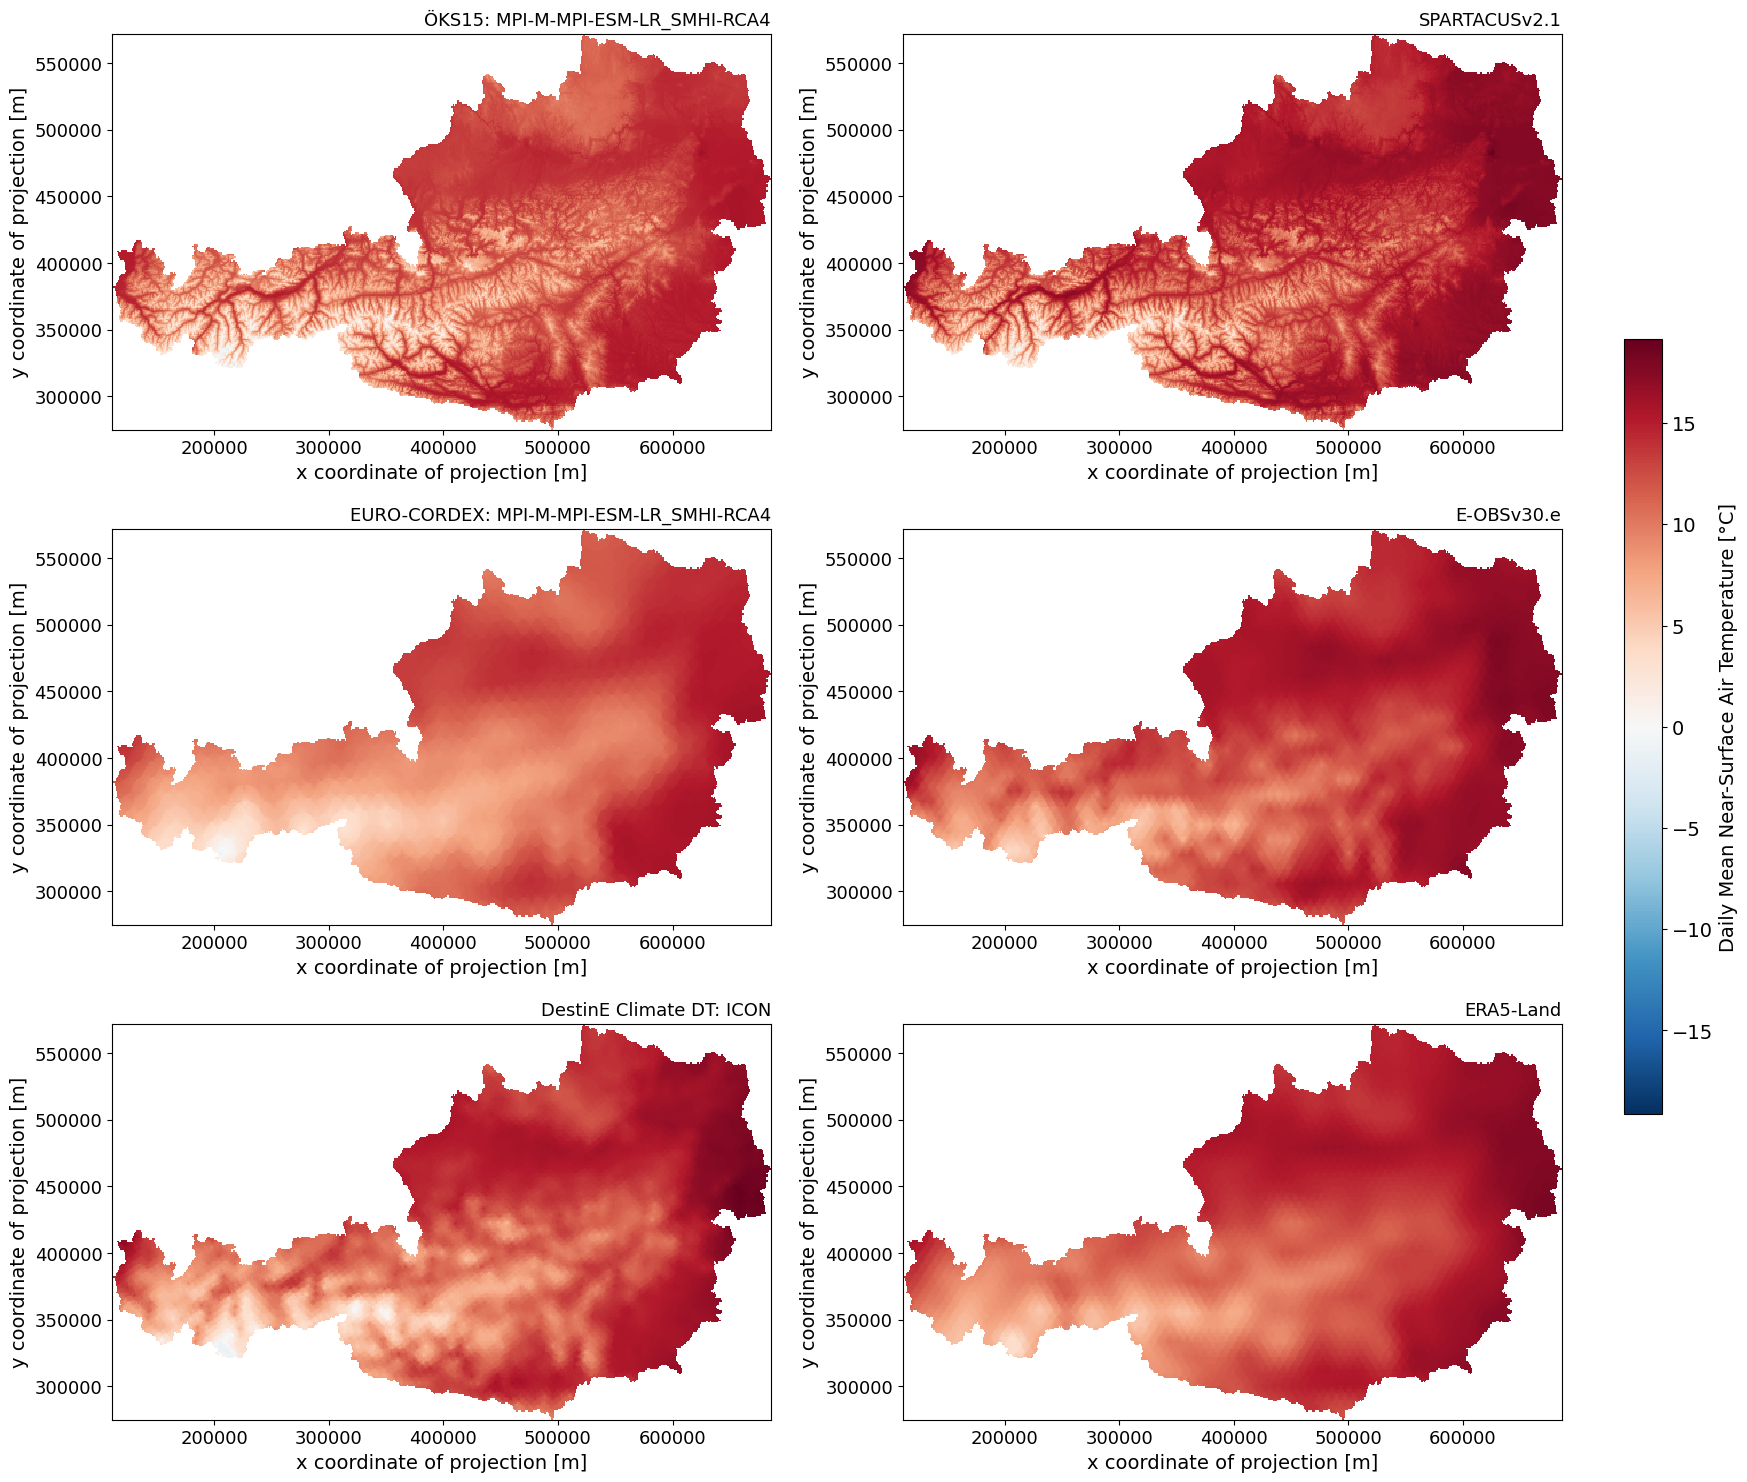

In [46]:
# creating a figure and 3x2 grid of subplots
fig, axs = plt.subplots(3, 2, figsize=(20, 18))
fig.subplots_adjust(hspace=0.25)

# plotting each dataset
cax1 = axs[0, 0].pcolormesh(t_mean_oeks15['x'], t_mean_oeks15['y'],  t_mean_oeks15, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[0, 0].set_title('ÖKS15: MPI-M-MPI-ESM-LR_SMHI-RCA4', size=13, loc='right')
axs[0, 0].tick_params(axis='x', labelsize=13)
axs[0, 0].tick_params(axis='y', labelsize=13)
axs[0, 0].set_xlabel('x coordinate of projection [m]', size = 14)
axs[0, 0].set_ylabel('y coordinate of projection [m]', size = 14)

cax2 = axs[0, 1].pcolormesh(t_mean_spartacus['x'], t_mean_spartacus['y'], t_mean_spartacus, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[0, 1].set_title('SPARTACUSv2.1', size=13, loc='right')
axs[0, 1].tick_params(axis='x', labelsize=13)
axs[0, 1].tick_params(axis='y', labelsize=13)
axs[0, 1].set_xlabel('x coordinate of projection [m]', size = 14)
axs[0, 1].set_ylabel('y coordinate of projection [m]', size = 14)

cax3 = axs[1, 0].pcolormesh(t_mean_eurocordex['x'], t_mean_eurocordex['y'], t_mean_eurocordex, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[1, 0].set_title('EURO-CORDEX: MPI-M-MPI-ESM-LR_SMHI-RCA4', size=13, loc='right')
axs[1, 0].tick_params(axis='x', labelsize=13)
axs[1, 0].tick_params(axis='y', labelsize=13)
axs[1, 0].set_xlabel('x coordinate of projection [m]', size = 14)
axs[1, 0].set_ylabel('y coordinate of projection [m]', size = 14)

cax4 = axs[1, 1].pcolormesh(t_mean_eobs['x'], t_mean_eobs['y'], t_mean_eobs, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[1, 1].set_title('E-OBSv30.e', size=13, loc='right')
axs[1, 1].tick_params(axis='x', labelsize=13)
axs[1, 1].tick_params(axis='y', labelsize=13)
axs[1, 1].set_xlabel('x coordinate of projection [m]', size = 14)
axs[1, 1].set_ylabel('y coordinate of projection [m]', size = 14)

cax5 = axs[2, 0].pcolormesh(t_mean_destine['x'], t_mean_destine['y'], t_mean_destine, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[2, 0].set_title('DestinE Climate DT: ICON', size=13, loc='right')
axs[2, 0].tick_params(axis='x', labelsize=13)
axs[2, 0].tick_params(axis='y', labelsize=13)
axs[2, 0].set_xlabel('x coordinate of projection [m]', size = 14)
axs[2, 0].set_ylabel('y coordinate of projection [m]', size = 14)

cax6 = axs[2, 1].pcolormesh(t_mean_era5['x'], t_mean_era5['y'], t_mean_era5, cmap='RdBu_r', vmin=-lim, vmax=lim)
axs[2, 1].set_title('ERA5-Land', size=13, loc='right')
axs[2, 1].tick_params(axis='x', labelsize=13)
axs[2, 1].tick_params(axis='y', labelsize=13)
axs[2, 1].set_xlabel('x coordinate of projection [m]', size = 14)
axs[2, 1].set_ylabel('y coordinate of projection [m]', size = 14)

# adding a single colorbar for all subplots
cbar = fig.colorbar(cax1, ax=axs, orientation='vertical', fraction=0.025, pad=0.04)
cbar.set_label('Daily Mean Near-Surface Air Temperature [°C]', size = 14)
cbar.ax.tick_params(labelsize=14)

#### 5.2 Timeseries

We can use `Matplotlib` also to produce a temporal comparison of daily mean temperatures aross the six datasets for September 2020.

The timeseries completes the spatial plots (*5.1*) by also showing the relative agreement between the different datasets on a daily basis.

Dashed lines correspond to observation based datasets (*SPARTACUSv2.1*, *E-OBSv30.e*, *ERA5-Land*), solid lines represent model simulations. 

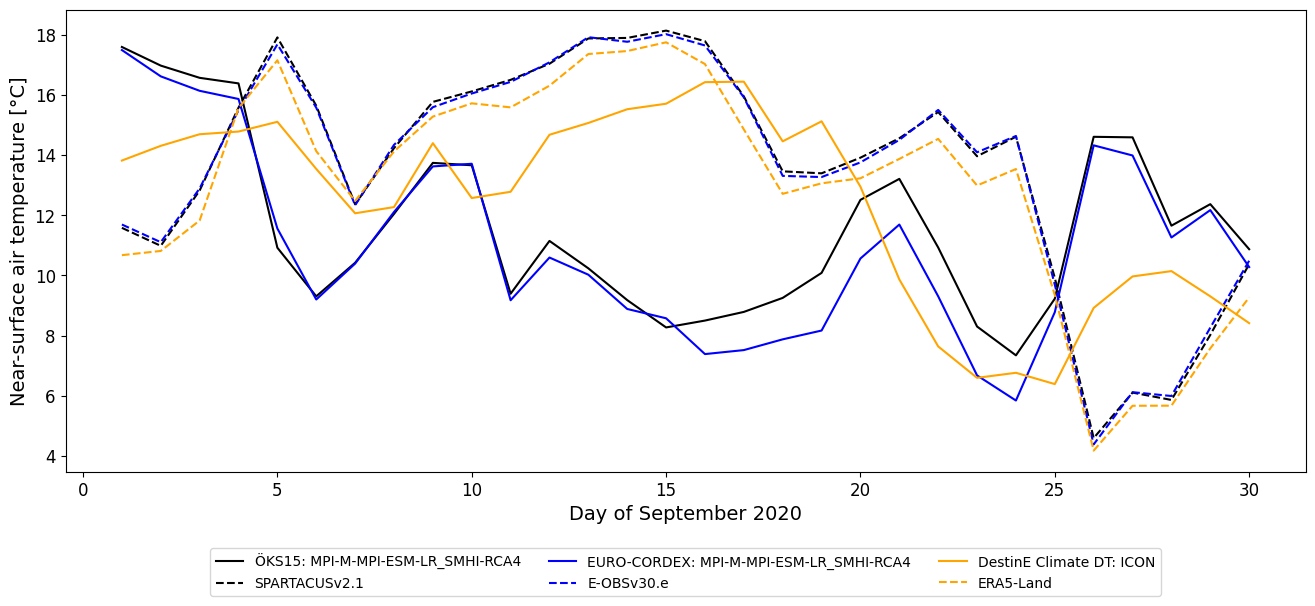

In [47]:
# array representing days of september
days_of_september = np.arange(1,31,1)

# plting six lines, each representing one dataset
plt.figure(figsize=(16,6))
plt.plot(days_of_september, t_timeseries_oeks15, label='ÖKS15: MPI-M-MPI-ESM-LR_SMHI-RCA4', color='black')
plt.plot(days_of_september, t_timeseries_spartacus, label='SPARTACUSv2.1', color='black', ls='--')
plt.plot(days_of_september, t_timeseries_eurocordex, label = 'EURO-CORDEX: MPI-M-MPI-ESM-LR_SMHI-RCA4', color='blue')
plt.plot(days_of_september, t_timeseries_eobs, label='E-OBSv30.e', color='blue', ls='--')
plt.plot(days_of_september, t_timeseries_destine, label='DestinE Climate DT: ICON', color='orange')
plt.plot(days_of_september, t_timeseries_era5, label='ERA5-Land', color='orange', ls='--')
plt.xticks(size=12)
plt.yticks(size=12)
plt.xlabel('Day of September 2020', size=14)
plt.ylabel('Near-surface air temperature [°C]', size=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=10)

#### 5.3 Boxplots

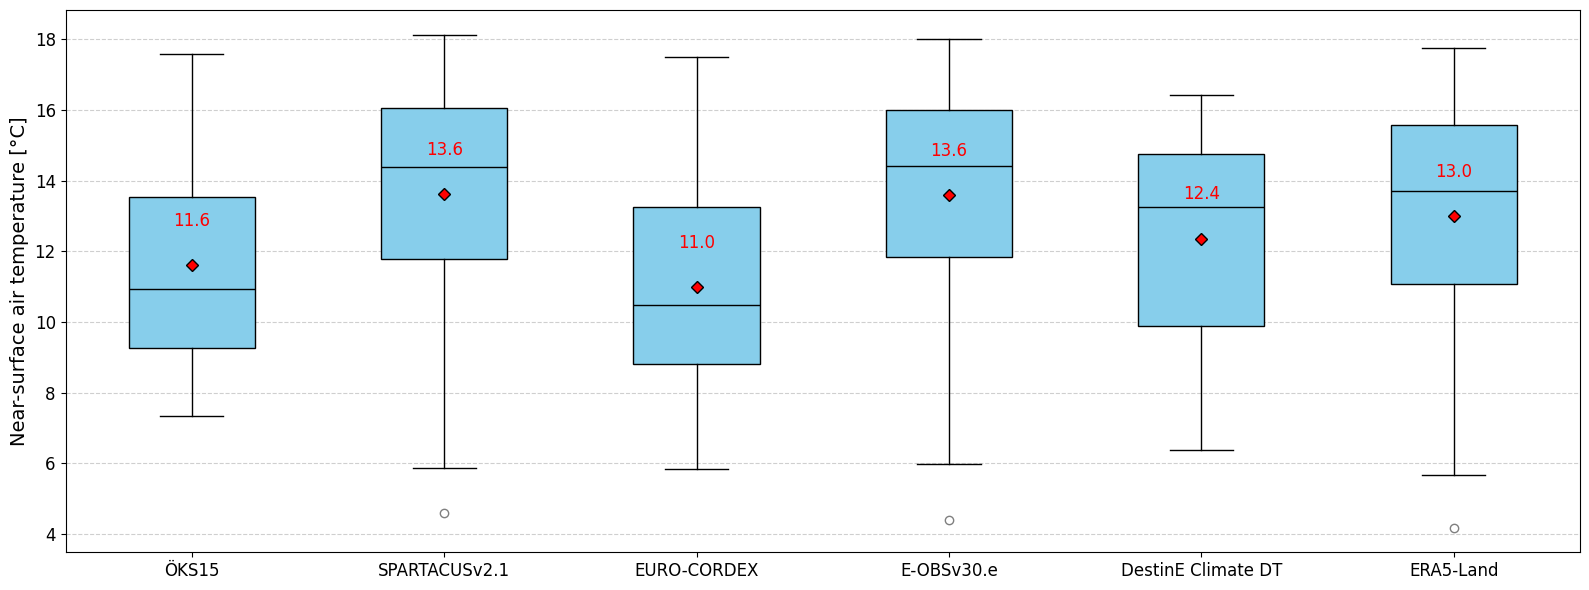

In [48]:
# dataset labels
datasets = ['ÖKS15',
            'SPARTACUSv2.1',
            'EURO-CORDEX',
            'E-OBSv30.e',
            'DestinE Climate DT',
            'ERA5-Land']

# corresponding values
values = [t_timeseries_oeks15,
          t_timeseries_spartacus,
          t_timeseries_eurocordex,
          t_timeseries_eobs,
          t_timeseries_destine,
          t_timeseries_era5]

# corresponding average values
mean_values = [t_average_oeks15,
               t_average_spartacus,
               t_average_eurocordex,
               t_average_eobs,
               t_average_destine,
               t_average_era5]

# plotting boxplot, each representing on dataset
plt.figure(figsize=(16, 6))
box = plt.boxplot(values, patch_artist=True,
                  boxprops=dict(facecolor='skyblue', color='black'),
                  medianprops=dict(color='black'),
                  whiskerprops=dict(color='black'),
                  capprops=dict(color='black'),
                  flierprops=dict(marker='o', color='red', alpha=0.5),
                  showmeans=True,
                  meanprops=dict(marker='D', markerfacecolor='red', markeredgecolor='black'))

# Annotate mean values just above the red diamond inside the plot
for i, mean in enumerate(mean_values, start=1):
    plt.text(i, mean + 1, f'{mean:.1f}', ha='center', va='bottom', fontsize=12, color='red')

plt.xticks(ticks=range(1, len(datasets) + 1), labels=datasets, fontsize=12)
plt.yticks(size=12)
plt.ylabel('Near-surface air temperature [°C]', size=14)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()